# Linear Regression Bakeoff

![Paul Hollywood gif](https://media.giphy.com/media/OjrcZp4fXMHBryKoXZ/giphy.gif)

### Inferential vs. Predictive
You should think of this primarily as a project in **inferential** statistics. That means:
- focusing on trying to satisfy the assumptions of linear regression;
- using all your records to build models;
- aiming for understanding how features influence sales prices.

But we also invite you to a level-up: a friendly competition among the teams. And here the goal is **predictive**. That means:
- maximizing $R^2$;
- utilizing train-test splits;
- utilizing validation sets (or cross-validation).
We’ll have SOME UNLABELED TEST DATA FOR YOU TO PLUG INTO YOUR MODELS.


# Training Data

Like a Kaggle competition, you are provided with the following training data representing 3/4 of the data set.  
It is split into **predictive features** (X_train) and **target variable** (y_train)

In [1]:
import numpy as np
import pandas as pd 
from scipy import stats
import warnings

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns

import time
start_time = time.time()
%matplotlib inline

X_train = pd.read_csv('bakeoff_data/Xtrain.csv')
y_train = pd.read_csv('bakeoff_data/ytrain.csv')
X_test = pd.read_csv('bakeoff_data/Xtest.csv')

In [2]:
X_test.shape

(5400, 19)

In [3]:
print(X_train.shape)

(16197, 19)


In [4]:
print(y_train.shape)

(16197, 1)


In [5]:
X_train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,3/4/2015,3,2.50,1880,4499,2.0,0.0,0.0,3,8,1880,0.0,1993,0.0,98029,47.5664,-121.999,2130,5114
1,10/7/2014,3,2.50,2020,6564,1.0,0.0,0.0,3,7,1310,710.0,1994,0.0,98042,47.3545,-122.158,1710,5151
2,1/16/2015,5,4.00,4720,493534,2.0,0.0,0.0,5,9,3960,760.0,1975,0.0,98027,47.4536,-122.009,2160,219542
3,3/30/2015,2,2.00,1430,3880,1.0,0.0,0.0,4,7,1430,0.0,1949,0.0,98117,47.6844,-122.392,1430,3880
4,10/14/2014,3,2.25,2270,32112,1.0,0.0,0.0,4,8,1740,530.0,1980,0.0,98042,47.3451,-122.094,2310,41606


In [6]:
X_train.isna().sum()

date                0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       1756
view               49
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     2879
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [7]:
X_train.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,16197.000000,16197.000000,16197.000000,1.619700e+04,16197.000000,14441.000000,16148.000000,16197.000000,16197.000000,16197.000000,16197.000000,13318.000000,16197.000000,16197.000000,16197.000000,16197.000000,16197.000000
mean,3.372229,2.116426,2083.693030,1.507189e+04,1.494752,0.007686,0.232165,3.410385,7.658702,1790.467926,1971.019942,81.993843,98078.100080,47.560975,-122.213720,1987.809286,12784.065074
std,0.905951,0.768049,918.209756,4.077585e+04,0.540474,0.087338,0.766092,0.650777,1.169277,827.598600,29.325399,396.213694,53.486457,0.138273,0.141639,685.189105,26833.379871
min,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.000000,1.750000,1430.000000,5.058000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,1952.000000,0.000000,98033.000000,47.472500,-122.329000,1490.000000,5100.000000
50%,3.000000,2.250000,1912.000000,7.620000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.573300,-122.231000,1840.000000,7620.000000
75%,4.000000,2.500000,2560.000000,1.072000e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2220.000000,1997.000000,0.000000,98117.000000,47.678300,-122.124000,2360.000000,10086.000000
max,11.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [8]:
X_test.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,5400.000000,5400.000000,5400.000000,5.400000e+03,5400.000000,4780.000000,5386.000000,5400.000000,5400.000000,5400.000000,5400.000000,4437.000000,5400.000000,5400.000000,5400.000000,5400.000000,5400.000000
mean,3.376111,2.114028,2070.210185,1.518194e+04,1.492130,0.007322,0.238953,3.408148,7.655556,1782.984630,1970.938889,88.568177,98077.507222,47.557447,-122.214770,1983.054074,12680.953148
std,0.984894,0.771851,917.805949,4.327026e+04,0.537347,0.085265,0.764518,0.649909,1.184994,828.294279,29.526848,410.952944,53.595322,0.139365,0.137951,685.405621,28558.979278
min,1.000000,0.750000,410.000000,6.090000e+02,1.000000,0.000000,0.000000,1.000000,4.000000,410.000000,1900.000000,0.000000,98001.000000,47.162200,-122.515000,670.000000,659.000000
25%,3.000000,1.750000,1420.000000,5.001000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98032.000000,47.465725,-122.327000,1480.000000,5100.000000
50%,3.000000,2.250000,1910.000000,7.616500e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1550.000000,1975.000000,0.000000,98065.000000,47.568900,-122.228000,1830.000000,7619.500000
75%,4.000000,2.500000,2520.000000,1.058800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2200.000000,1997.000000,0.000000,98118.000000,47.677500,-122.127000,2370.000000,10080.000000
max,33.000000,7.750000,10040.000000,1.164794e+06,3.000000,1.000000,4.000000,5.000000,13.000000,8860.000000,2015.000000,2015.000000,98199.000000,47.777500,-121.315000,5790.000000,858132.000000


In [9]:
X_test[X_test.bedrooms == 33]

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2667,6/25/2014,33,1.75,1620,6000,1.0,0.0,0.0,5,7,1040,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700


<AxesSubplot:>

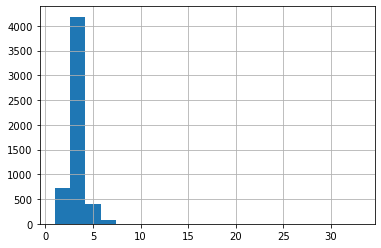

In [10]:
X_test.bedrooms.hist(bins=20)

### Data Cleaning X_train

In [11]:
# Set Nan values of 'waterfront' and 'year_renovated' columns to 0
X_train.loc[X_train.waterfront.isna()==True, 'waterfront'] = 0
X_train.loc[X_train.yr_renovated.isna()==True, 'yr_renovated'] = 0

#Set all sqft_basement values of '?' to 0, then convert to floats.
X_train.loc[X_train.sqft_basement=='?', 'sqft_basement'] = 0
X_train.sqft_basement = X_train.sqft_basement.astype(float)

# Convert 'date' to a datetime object and use these to create a 'year' column
X_train['date'] = pd.to_datetime(X_train['date'])
X_train['year'] = X_train['date'].apply(lambda date: date.year)

# Create an 'age' column to specify how old a house was at sale
X_train['age'] = X_train['year'] - X_train['yr_built']

#Drop unnecessary 'id', 'yr_built', 'year', and 'date' columns
cols_to_drop = ['yr_built', 'year', 'date']
X_train.drop(cols_to_drop, axis=1, inplace=True)

#Drop rows that contain null values in the 'view' column
X_train.loc[X_train.view.isna()==True, 'view'] = X_train.view.mean()

### Data Cleaning X_test

In [12]:
# Set Nan values of 'waterfront' and 'year_renovated' columns to 0
X_test.loc[X_test.waterfront.isna()==True, 'waterfront'] = 0
X_test.loc[X_test.yr_renovated.isna()==True, 'yr_renovated'] = 0

#Set all sqft_basement values of '?' to 0, then convert to floats.
X_test.loc[X_test.sqft_basement=='?', 'sqft_basement'] = 0
X_test.sqft_basement = X_test.sqft_basement.astype(float)

# Convert 'date' to a datetime object and use these to create a 'year' column
X_test['date'] = pd.to_datetime(X_test['date'])
X_test['year'] = X_test['date'].apply(lambda date: date.year)

# Create an 'age' column to specify how old a house was at sale
X_test['age'] = X_test['year'] - X_test['yr_built']

#Drop unnecessary 'id', 'yr_built', 'year', and 'date' columns
cols_to_drop = ['yr_built', 'year', 'date']
X_test.drop(cols_to_drop, axis=1, inplace=True)

#Drop rows that contain null values in the 'view' column
X_test.loc[X_test.view.isna()==True, 'view'] = X_test.view.mean()

In [13]:
def outliers(df):
    # assigning variable for columns we would like to check for outliers
    target_cols = ['bathrooms', 'bedrooms', 'sqft_living']
    # assigning variable to predefined outlier column names
    outlier_cols = ['outlier_' + col for col in target_cols]
    z_scores = [stats.zscore(df[col]) 
                    for col in target_cols]
    # for each column, checking to see if the z-score is above or below 3 standard deviations
    for outlier_col, z_score in zip(outlier_cols, z_scores):
        df[outlier_col] = ((z_score > 3) | (z_score <-3))
    # initializes an empty query string 
    query_empty = '({} == True)&'*(len(target_cols))
    # fills in the outlier column names
    query = query_empty[:-1].format(*outlier_cols)
    # selecting rows that do not have any outliers
    df = df.query(query)
    # dropping the outlier columns that we just made
    df.loc[query, target_cols] = df[target_cols].mean().values
    # Drop the outlier house that contains 33 bedrooms
    df.loc[df['bedrooms'] == 33, 'bedrooms'] = 3
    # Drop houses that were bought before construction
    df.loc[df['age'] == -1, 'age'] = 0

    
    return df

In [14]:
outliers(X_train)
outliers(X_test)

<ipython-input-13-2effe8b5ea6b>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[query, target_cols] = df[target_cols].mean().values
<ipython-input-13-2effe8b5ea6b>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[query, target_cols] = df[target_cols].mean().values


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,age,outlier_bathrooms,outlier_bedrooms,outlier_sqft_living
(outlier_bathrooms == True)&(outlier_bedrooms == True)&(outlier_sqft_living == True),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
X_train.drop(['outlier_bathrooms', 'outlier_bedrooms', 'outlier_sqft_living'], axis=1, inplace=True)
X_test.drop(['outlier_bathrooms', 'outlier_bedrooms', 'outlier_sqft_living'], axis=1, inplace=True)

In [16]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5400 entries, 0 to 5399
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       5400 non-null   int64  
 1   bathrooms      5400 non-null   float64
 2   sqft_living    5400 non-null   int64  
 3   sqft_lot       5400 non-null   int64  
 4   floors         5400 non-null   float64
 5   waterfront     5400 non-null   float64
 6   view           5400 non-null   float64
 7   condition      5400 non-null   int64  
 8   grade          5400 non-null   int64  
 9   sqft_above     5400 non-null   int64  
 10  sqft_basement  5400 non-null   float64
 11  yr_renovated   5400 non-null   float64
 12  zipcode        5400 non-null   int64  
 13  lat            5400 non-null   float64
 14  long           5400 non-null   float64
 15  sqft_living15  5400 non-null   int64  
 16  sqft_lot15     5400 non-null   int64  
 17  age            5400 non-null   int64  
dtypes: float

In [17]:
X_test.shape

(5400, 18)

### Add dummy zipcodes to X_train and X_test

In [18]:
# Adds dummy zipcode columns
X_test = X_test.join(pd.get_dummies(X_test['zipcode'], prefix = 'x', drop_first = True))
X_test.drop('zipcode', axis=1, inplace=True)

In [19]:
X_train = X_train.join(pd.get_dummies(X_train['zipcode'], prefix = 'x', drop_first = True))
X_train.drop('zipcode', axis=1, inplace=True)

In [20]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16197 entries, 0 to 16196
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   16197 non-null  float64
dtypes: float64(1)
memory usage: 126.7 KB


In [21]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5400 entries, 0 to 5399
Data columns (total 86 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       5400 non-null   int64  
 1   bathrooms      5400 non-null   float64
 2   sqft_living    5400 non-null   int64  
 3   sqft_lot       5400 non-null   int64  
 4   floors         5400 non-null   float64
 5   waterfront     5400 non-null   float64
 6   view           5400 non-null   float64
 7   condition      5400 non-null   int64  
 8   grade          5400 non-null   int64  
 9   sqft_above     5400 non-null   int64  
 10  sqft_basement  5400 non-null   float64
 11  yr_renovated   5400 non-null   float64
 12  lat            5400 non-null   float64
 13  long           5400 non-null   float64
 14  sqft_living15  5400 non-null   int64  
 15  sqft_lot15     5400 non-null   int64  
 16  age            5400 non-null   int64  
 17  x_98002        5400 non-null   uint8  
 18  x_98003 

### Drop columns in X_train and X_test.  Log transform y_train.

In [22]:
X_train = X_train.drop(['sqft_basement', 'bedrooms', 'sqft_above'], axis = 1)
X_test = X_test.drop(['sqft_basement', 'bedrooms', 'sqft_above'], axis = 1)
y_train = np.log(y_train)

### Gradient Boosting

In [23]:
gbr = ensemble.GradientBoostingRegressor(learning_rate = 0.06, 
                                         n_estimators = 600, max_depth = 5)
gbr.fit(X_train, y_train)
gbr_train = gbr.score(X_train, y_train)
#gbr_test = gbr.score(X_test, y_test)
pred_gbr = gbr.predict(X_test)
#rmse_gbr = mean_squared_error(np.exp(y_test), np.exp(pred_gbr), squared=False)
gbr_train

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.9472183427385918

In [35]:
pred_gbr_exp = np.exp(pred_gbr)
pred_gbr_exp.mean()

529354.9554161102

### Random Forest

In [26]:
# Call Random Forest and set the estimators to 150
rf = RandomForestRegressor(n_estimators=150)
# Fit the model
rf.fit(X_train, y_train)
# Get the scores
score_rf = rf.score(X_train, y_train)
#score_rf_test = rf.score(X_test, y_test)
# Get the predictions
predict_rf = rf.predict(X_test)

#rmse_rfr = mean_squared_error(np.exp(y_test),np.exp(predict_rf), squared=False)
score_rf

<ipython-input-26-c8eecd613704>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


0.9840109645806863

In [36]:
predict_rf_exp = np.exp(predict_rf)
predict_rf_exp.mean()

524864.6330091438

### Train the model and determine R2 score. 

In [29]:
# Initialize an empty regression model
lr = LinearRegression()
# Fits the model to our training dataset
lr.fit(X_train, y_train)
# Predict price with the trained model
pred_lr = lr.predict(X_test)
# Get the coefficient of determination for training and test data
train_score_lr = lr.score(X_train, y_train)
# Take a peak at model coef
lr.coef_[0]
# Baseline housing cost without features
lr.intercept_
# Normalizing our price to get an RMSE
train_score_lr  #0.87538759994488

0.87538759994488

### Statsmodel

In [30]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16197 entries, 0 to 16196
Data columns (total 83 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bathrooms      16197 non-null  float64
 1   sqft_living    16197 non-null  int64  
 2   sqft_lot       16197 non-null  int64  
 3   floors         16197 non-null  float64
 4   waterfront     16197 non-null  float64
 5   view           16197 non-null  float64
 6   condition      16197 non-null  int64  
 7   grade          16197 non-null  int64  
 8   yr_renovated   16197 non-null  float64
 9   lat            16197 non-null  float64
 10  long           16197 non-null  float64
 11  sqft_living15  16197 non-null  int64  
 12  sqft_lot15     16197 non-null  int64  
 13  age            16197 non-null  int64  
 14  x_98002        16197 non-null  uint8  
 15  x_98003        16197 non-null  uint8  
 16  x_98004        16197 non-null  uint8  
 17  x_98005        16197 non-null  uint8  
 18  x_9800

In [31]:
X = sm.add_constant(X_train)
sm.OLS(y_train, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     1364.
Date:                Fri, 16 Jul 2021   Prob (F-statistic):               0.00
Time:                        16:02:10   Log-Likelihood:                 4246.4
No. Observations:               16197   AIC:                            -8325.
Df Residuals:                   16113   BIC:                            -7679.
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -58.9848      8.146     -7.241      0.000     -74.951     -43.018
bathrooms         0.0362      0.003     10.478      0.000       0.029       0.043
sqft_living       0.0002   3.47e-06     49.098      0.000       0.000       0.000
sqft_lot       6.026e-07   5.17e-08     11.645      0.000    5.01e-07    7.04e-07
floors           -0.0012      0.004     -0.323      0.746      -0.009       0.006
waterfront        0.4896      0.020     25.008      0.000       0.451       0.528
view              0.0545      0.002     23.597      0.000       0.050       0.059
condition         0.0523      0.003     20.356      0.000       0.047       0.057
grade             0.1001      0.002     41.884      0.000       0.095       0.105
yr_renovated   3.853e-05   4.33e-06      8.895      0.000       3e-05     4.7e-05
lat               0.5708      0.085      6.733      0.000       0.405       0.737
long             -0.3514      0.060     -5.855      0.000      -0.469      -0.234
sqft_living15  9.477e-05   3.88e-06     24.441      0.000    8.72e-05       0.000
sqft_lot15     5.398e-08   8.18e-08      0.659      0.510   -1.06e-07    2.14e-07
age               0.0007   8.56e-05      7.998      0.000       0.001       0.001
x_98002          -0.0127      0.020     -0.642      0.521      -0.051       0.026
x_98003          -0.0022      0.017     -0.128      0.898      -0.036       0.032
x_98004           0.9006      0.031     28.600      0.000       0.839       0.962
x_98005           0.5637      0.034     16.769      0.000       0.498       0.630
x_98006           0.4908      0.028     17.777      0.000       0.437       0.545
x_98007           0.5024      0.035     14.419      0.000       0.434       0.571
x_98008           0.5063      0.033     15.445      0.000       0.442       0.571
x_98010           0.3148      0.029     10.889      0.000       0.258       0.371
x_98011           0.2054      0.043      4.790      0.000       0.121       0.289
x_98014           0.2417      0.047      5.180      0.000       0.150       0.333
x_98019           0.1826      0.046      3.946      0.000       0.092       0.273
x_98022           0.1932      0.026      7.485      0.000       0.143       0.244
x_98023          -0.0757      0.016     -4.766      0.000      -0.107      -0.045
x_98024           0.4017      0.041      9.843      0.000       0.322       0.482
x_98027           0.4306      0.028     15.411      0.000       0.376       0.485
x_98028           0.1506      0.042      3.611      0.000       0.069       0.232
x_98029           0.5300      0.032     16.553      0.000       0.467       0.593
x_98030           0.0470      0.019      2.421      0.015       0.009       0.085
x_98031           0.0383      0.020      1.938      0.053      -0.000       0.077
x_98032          -0.0864      0.024     -3.659   

### Cross Validate

In [32]:
scores = cross_validate(
                    lr, X_train, y_train, cv=5, 
                    return_train_score=True
)
mean_train_score = np.mean(scores['train_score'])
train_score_std = np.std(scores['train_score'])
mean_test_score = np.mean(scores['test_score'])
test_score_std = np.std(scores['test_score'])

print('Mean Train score:', mean_train_score, ': Standard Deviation:', train_score_std)
print('Mean Test score:', mean_test_score, ': Standard Deviation:', test_score_std)

Mean Train score: 0.8755553043828836 : Standard Deviation: 0.0009434757652273278
Mean Test score: 0.8737720639290373 : Standard Deviation: 0.003688083475487965


As you can see, you have been provided with 19 independent features.  You may use as many of them as you like in your model.  The goal is to get the highest R^2 on the test data.

# Test Data

But how will you know that your model resulted in a high R^2 in the test data? You won't! At least, you won't know until the submission window has closed.  

You will notice that while you have a file named `Xtest.csv`, you do not have a file named `ytest.csv`. Your instructor has that in their posession, and will keep it secret from the bakeoff contestants.  

Once you have decided on your best model, you will then make predictions.  These predictions will be compared to the labels held in the hidden `ytest.csv`, resulting in a final R^2 score. In order for your submission to be valid, you have to have a prediction for every row of `Xtest.csv`.

Below, the `Xtest.csv` has been imported into this notebook for you.

In [33]:

X_test.head()


,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_renovated,lat,...,x_98146,x_98148,x_98155,x_98166,x_98168,x_98177,x_98178,x_98188,x_98198,x_98199
0,0.75,850,8573,1.0,0.0,0.0,3,6,0.0,47.5030,...,1,0,0,0,0,0,0,0,0,0
1,1.00,1510,6083,1.0,0.0,0.0,4,6,0.0,47.6966,...,0,0,0,0,0,0,0,0,0,0
2,2.25,1790,42000,1.0,0.0,0.0,3,7,0.0,47.4819,...,0,0,0,0,0,0,0,0,0,0
3,1.50,1140,2500,1.0,0.0,1.0,3,7,0.0,47.5707,...,0,0,0,0,0,0,0,0,0,0
4,1.00,1500,3920,1.0,0.0,0.0,3,7,0.0,47.6718,...,0,0,0,0,0,0,0,0,0,0


In [34]:
print(X_test.shape)

(5400, 83)


Notice how the cell above indicates that there are **5400** records in `X_test`.  You should therefore submit 5400 predicted saleprices.  

# Building Your Best Model

So how does one build a model that one has confidence will perform well on the test data? You could just fit the model on the training data, and consider the R^2.  But remember, no matter what, your training R^2  will always go up when you add more features. With that in mind, you could just implement a 6th degree polynomial transformation, and your training R^2 will be very high.  What will that mean in terms of the bias-variance tradeoff?  Your model will be highly complex and surely overfit. Therefore, you would expect it to perform poorly on the test set.

To get an idea of how your model will perform on unseen data, you will have to choose some method of creating a validation set within your training data.  

There are several ways to do that, and you will have to pick the method that you are most comfortable with.  

The simplest way would be to simply perform another train-test-split on your training data, fit your model on the larger part of that secondary split, and then score your model on the smaller validation set. 

The more comprehensive way would be to use the Sklearn cross-validation class or Kfolds.  If you specify 5 folds, then you train your model on 5 different sets of training data and 5 different sets of validation data.  You would then look at the mean R^2 of the 5 validation sets.

Your task will be to try out different hypotheses iteratively, and select the combination of predictors that explains the most variance.

# Generating Predictions

After you have selected your best combination of features, your work is not quite done. You have to use your trained model to make predictions.  In doing so, you have to watch out for a few stumbling points.

## 1: Retrain Your Model on the Entire Training Set

When you are iteratively building your model with cross-validation, you are required to leave out some data (the validation data) in the training process.  You always want to train your model on as much data as possible. The validation process tells you which features to use in your final model, but you need to then retrain your model on the entire training data using those features.  You could not perform this step, but your model will perform worse. 



## 2: Prepare your X_test Exactly as You Prepared your X_train

When selecting the best features for your model, you will most certainly alter your X_train data frame.  For example, maybe you did not include the `date` feature. After fitting your final model to a version of X_train without date, you then try to make a prediction on X_test.  Sklearn will complain that the dimensions of X_test do not match the demensions required on the fit model.  So, before making your predictions, you will have to drop the `date` column from X_test.  Any transformation you do to X_train will have to be performed on X_test. 

You will also have to deal with the missing values in the X_test.  There are 3 columns which include NA's.  You will not be able to drop rows containing missing values, since doing so will result in diminishing the number of predictions in your final set. If those columns are important to your model, you will have to fill the NA's in the test set just as you did in your training set. Of course, you could opt to not include those columns in your final model.





# Checking your Prediction Shape

You have selected the features for your best model, and trained your model on the entire data set.  You have transformed the X_test in the same way that you transformed your X_train.  You have made a set of predictions. 

In the cell below, you will find a fake y_test; it has been filled with zeros.

In [ ]:
import numpy as np
y_test_fake = np.full((5400,1), 0)

In order to test that your predictions are of the correct shape, feed your 5400 predicted values into the cell below.

In [ ]:
final_pred = np.exp(pred_lr)
final_pred.mean(), final_pred.shape

In [ ]:
from sklearn.metrics import r2_score

# fake predictions using the mean of y_train.
your_y_hat_predictions = np.full((5400,1), np.mean(y_train))

r2_score(final_pred, y_test_fake)

In [ ]:
final_pred.mean() #530613.0565927846

Only pay attention to errors thrown by the cell above, not the R^2.   If the cell does not throw any errors, your predictions are ready for submission.

Convert the array of predictions into a `csv` by filling in the placeholder filepath and variable name with the appropriate values.

In [38]:
np.savetxt('Group_4_RandomForest.csv', predict_rf_exp, delimiter=',')

There will be a Slack channel designated for submitting your final predictions `csv`. 

Only predictions received before 5 pm PST will be considered valid.  

The team with the highest R^2 will be deemed the Linear Regression Bakeoff winner.



In [ ]:
final_pred

![on you marks, get set, bake](https://media.giphy.com/media/l3vRhl6k5tb3oPGLK/giphy.gif)